In [110]:
%pylab inline
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import numpy as np

chunk = 'chunk21'

topdir = '/global/cscratch1/sd/huikong/obiwan_Aug/repos_for_docker/obiwan_out/subset/'
fn = 'eBOSS_ELG_full_ALL_v4.dat_really_masked_chunk21_200per_matched.fits'
fn_obiwan = 'sgc_run_obiwan_really_masked_chunk21.fits'
fn_sim = 'sgc_run_sim_really_masked_chunk21.fits'
DAT = fits.getdata(topdir+fn)
obiwan = fits.getdata(topdir+fn_obiwan)
SIM = fits.getdata(topdir+fn_sim)

fn = topdir+'sgc_200per_sm_tc_match_part1_really_masked_chunk21.fits'
sim = fits.getdata(fn)

Populating the interactive namespace from numpy and matplotlib


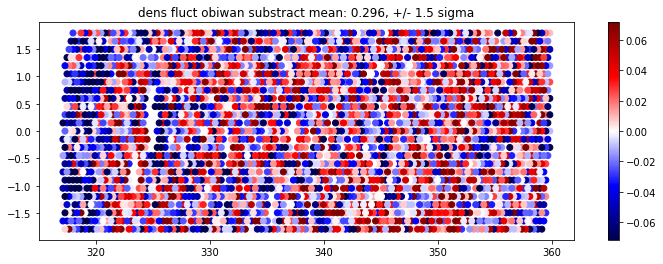

In [64]:
#obiwan density:
def MAG(mag, data = obiwan):
    g     = 22.5 - 2.5 * np.log10(data['flux_g'] / data['mw_transmission_g'])
    r_mag = 22.5 - 2.5 * np.log10(data['flux_r'] / data['mw_transmission_r'])
    z_mag = 22.5 - 2.5 * np.log10(data['flux_z'] / data['mw_transmission_z'])
    if mag == 'g':
        return g
    if mag == 'r':
        return r_mag
    if mag == 'z':
        return z_mag

def compare_obiwan(res = 256, obiwan = obiwan):
    import healpy as hp
    #mean <mag-mag_true> plot g,r,z
    pixs = hp.ang2pix(res,obiwan['ra'],obiwan['dec'],nest = True, lonlat = True)
    pixs2 = hp.ang2pix(res,SIM['ra'], SIM['dec'], nest = True, lonlat = True)
    pixs3 = hp.ang2pix(res,DAT['ra'],DAT['dec'],nest = True, lonlat = True)
    N = 12*res**2
    hist_n = np.zeros(N)
    hist_mag_diff_g = np.zeros(N)
    hist_mag_diff_r = np.zeros(N)
    hist_mag_diff_z = np.zeros(N)
    mag_g = MAG('g',data = obiwan)
    mag_r =  MAG('r', data = obiwan)
    mag_z = MAG('z', data = obiwan)
    
    for i in range(len(pixs)):
        n = pixs[i]
        mag_diff_g = mag_g[i] - obiwan['sim_gflux'][i]
        mag_diff_r = mag_r[i] - obiwan['sim_rflux'][i]
        mag_diff_z = mag_z[i] - obiwan['sim_zflux'][i]
        hist_mag_diff_g[n]+=mag_diff_g
        hist_mag_diff_r[n]+=mag_diff_r
        hist_mag_diff_z[n]+=mag_diff_z
        hist_n[n]+=1
    hist2 = np.zeros(N)
    for i in range(len(pixs2)):
        n = pixs2[i]
        hist2[n]+=1
    hist3 = np.zeros(N)
    for i in range(len(pixs3)):
        n = pixs3[i]
        hist3[n]+=1

    
    N = 12*res**2
    ra,dec = hp.pix2ang(res,np.arange(N), nest = True,lonlat = True)
    col1 = fits.Column(name = 'ra', array = ra, format = 'D')
    col2 = fits.Column(name = 'dec', array = dec, format = 'D')
    # # of obiwans in each pixel
    col3 = fits.Column(name = 'num_obiwan', array = hist_n, format = 'D')
    col4 = fits.Column(name = 'hist_mag_diff_g', array = hist_mag_diff_g, format = 'D')
    col5 = fits.Column(name = 'hist_mag_diff_r', array = hist_mag_diff_r, format = 'D')
    col6 = fits.Column(name = 'hist_mag_diff_z', array = hist_mag_diff_z, format = 'D')
    # # of uniform randoms in each pixel
    col7 = fits.Column(name = 'num_uniform', array = hist2, format = 'D')
    # # of real elgs in each pixel
    col8 = fits.Column(name = 'num_elgs', array = hist3, format = 'D')
    
    #bad pixels
    g = obiwan['sim_gflux']
    rz = obiwan['sim_rflux'] - obiwan['sim_zflux']
    gr = obiwan['sim_gflux'] - obiwan['sim_rflux']
    color_sgc = (g>21.825)&(g<22.825)&(-0.068*rz+0.457<gr)&(gr< 0.112*rz+0.773) &(0.218*gr+0.571<rz)&(rz<-0.555*gr+1.901)
    dat_bad = obiwan[color_sgc==False]
    pixs_bad = hp.ang2pix(res,dat_bad['ra'],dat_bad['dec'],nest = True, lonlat = True)
    hist_bad = np.zeros(N)
    for i in range(len(pixs_bad)):
        n = pixs_bad[i]
        hist_bad[n]+=1
    col9 = fits.Column(name = 'num_bad', array = hist_bad, format = 'D')
    dat = fits.BinTableHDU.from_columns([col1,col2,col3,col4,col5,col6,col7,col8,col9]).data
    uni = dat['num_uniform']
    sel = (uni>0)
    return dat[sel]
#obiwan rearanged in healpix format

compact_obiwan = compare_obiwan()
def plot_density(colname = 'num_obiwan',Type = 'obiwan'):
    
    #have a cut 10%
    p = np.percentile(compact_obiwan['num_uniform'], 10)
    hp_obiwan = compact_obiwan[compact_obiwan['num_uniform']>p]

    color = hp_obiwan[colname]/hp_obiwan['num_uniform']
    mean = color.mean()
    std = color.std()
    plt.scatter(hp_obiwan['ra'],hp_obiwan['dec'],c=color-mean,cmap = 'seismic',vmin = -std*1.5,vmax = 1.5*std)
    plt.colorbar()
    plt.title('dens fluct '+ Type +' substract mean: %.3f, +/- 1.5 sigma' % mean)
plt.figure(figsize=(12,4))
plot_density()

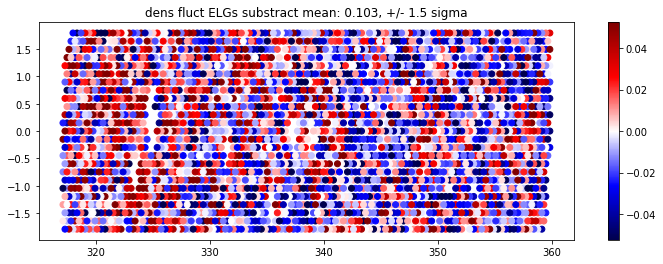

In [17]:
plt.figure(figsize=(12,4))
plot_density(colname = 'num_elgs', Type = 'ELGs')

In [42]:
def goot_out_ratio(quantity_in, quantity_out, good_in,bad_out,number,quanti,sim = sim):
    mag_in = quantity_in
    mag_out = quantity_out
    sel_good = eval('mag_in'+good_in+str(number))
    mag_good = eval('mag_out'+'[sel_good]')
    sim_good = sim[sel_good]
    sel_bad  = eval('mag_good'+bad_out+str(number))&(sim_good['matched']==True)
    sim_bad = sim_good[sel_bad]
    print(len(sim_good),len(sim_bad),len(sim_bad)/len(sim_good),len(sim))
    
    import healpy as hp
    res=256
    npo = 12*res**2
    pixs = np.arange(npo)
    pix_good = hp.ang2pix(res, sim_good['ra'], sim_good['dec'], nest = False, lonlat = True)
    pix_bad = hp.ang2pix(res, sim_bad['ra'], sim_bad['dec'], nest = False, lonlat = True)
    ra,dec = hp.pix2ang(res, pixs, nest = False, lonlat = True)
    good_arr = np.zeros(npo)
    bad_arr = np.zeros(npo)
    pixs = np.arange(npo)
    for i in range(len(pix_good)):
        n = pix_good[i]
        good_arr[n]+=1
    for i in range(len(pix_bad)):
        n = pix_bad[i]
        bad_arr[n]+=1
        
    good_arr_new = good_arr[good_arr>0]
    p = np.percentile(good_arr_new,10)
    plt.figure(figsize=(12,3))
    good_arr_new = good_arr[good_arr>p]
    bad_arr_new = bad_arr[good_arr>p]
    ra_new = ra[good_arr>p]
    dec_new = dec[good_arr>p]
    mean = (bad_arr_new/good_arr_new).mean()
    std = (bad_arr_new/good_arr_new).std()
    plt.scatter(ra_new,dec_new, c= bad_arr_new/good_arr_new,marker = 'o',vmax = mean+1.5*std,vmin = 1.5*std)
    plt.gca().set_xlim((315,350))
    plt.gca().set_ylim((-2,2))
    plt.colorbar()
    plt.title('points go from '+quanti+good_in+str(number)+' to '+quanti+bad_out+str(number))
    return bad_arr,good_arr,ra,dec

In [134]:
def sim_go_bad_ratio_1D(quantity_in, quantity_out, good_in,bad_out,number,quanti,bins = 20, sim = sim):
    low = np.percentile(quantity_in, 0)
    high = np.percentile(quantity_in, 100)
    intervals = (high-low)/bins
    binning_left = np.array([low+i*intervals for i in range(bins)])
    binning_right = np.array([low+(i+1)*intervals for i in range(bins)])
    y_axis = np.zeros(bins)
    for i in range(bins):
        sel1 = eval('quantity_in'+'>'+str(binning_left[i]))
        sel2 = eval('quantity_in'+'<'+str(binning_right[i]))
        sel3 = eval('quantity_in'+good_in+str(number))
        dat_in_good = sim[sel1&sel2&sel3]
        num_in_good = len(dat_in_good)
        sel4 = eval('quantity_out'+bad_out+str(number))
        num_out_bad = len(sim[sel1&sel2&sel3&sel4])
        if num_in_good>0:
            y_axis[i] += num_out_bad/num_in_good
        else:
            y_axis[i] += -0.5
    x_axis = (binning_left+binning_right)/2  
    y_axis_new = y_axis[y_axis>-0.1]
    x_axis_new = x_axis[y_axis>-0.1]
    plt.plot(x_axis_new,y_axis_new,'o--')
    plt.xlabel('averge '+quanti)
    plt.ylabel('ratio')
    
    
    return y_axis.max()
    
def sim_contamination_ratio_1D(quantity_in, quantity_out, good_in,bad_out,number,quanti,bins = 20, sim = sim):
    low = np.percentile(quantity_in, 0)
    high = np.percentile(quantity_in, 100)
    intervals = (high-low)/bins
    intervals = (high-low)/bins
    binning_left = np.array([low+i*intervals for i in range(bins)])
    binning_right = np.array([low+(i+1)*intervals for i in range(bins)])
    y_axis = np.zeros(bins)
    for i in range(bins):
        sel1 = eval('quantity_in'+'>'+str(binning_left[i]))
        sel2 = eval('quantity_in'+'<'+str(binning_right[i]))
        sel3 = eval('quantity_in'+bad_out+str(number))
        dat_in_bad = sim[sel1&sel2&sel3]
        num_in_bad = len(dat_in_bad)
        sel4 = eval('quantity_out'+good_in+str(number))
        num_out_good = len(sim[sel1&sel2&sel3&sel4])
        if num_in_bad>0:
            y_axis[i] += num_out_good/num_in_bad
        else:
            y_axis[i] += -0.5
    x_axis = (binning_left+binning_right)/2  
    y_axis_new = y_axis[y_axis>-0.1]
    x_axis_new = x_axis[y_axis>-0.1]
    plt.plot(x_axis_new,y_axis_new,'o--')
    return y_axis.max()

def scatter_contamination_plotting(quantity_in, quantity_out, good_in,bad_out,number,quanti,bins = 20, sim = sim):
    m1 = sim_go_bad_ratio_1D(quantity_in, quantity_out, good_in,bad_out,number,quanti,bins = 20, sim = sim)
    m2 = sim_contamination_ratio_1D(quantity_in, quantity_out, good_in,bad_out,number,quanti,bins = 20, sim = sim)
    y = np.arange(0,max(m1,m2),0.01)
    x = np.ones(len(y))*number
    plt.title(quanti+good_in+str(number)+' ELGs scatter in/out plot')
    plt.grid()
    plt.plot(x,y,'k--')

In [49]:
out_r = 22.5 - 2.5 * np.log10(sim['flux_r'] / sim['mw_transmission_r'])
out_z = 22.5 - 2.5 * np.log10(sim['flux_z'] / sim['mw_transmission_z'])
out_g = 22.5 - 2.5 * np.log10(sim['flux_g'] / sim['mw_transmission_g'])
in_r = 22.5 - 2.5 * np.log10(sim['sim_rflux'] / sim['sim_mw_transmission_r'])
in_z = 22.5 - 2.5 * np.log10(sim['sim_zflux'] / sim['sim_mw_transmission_z'])
in_g = 22.5 - 2.5 * np.log10(sim['sim_gflux'] / sim['sim_mw_transmission_g'])

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()


/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in log10


3112 2667 0.8570051413881749 372756


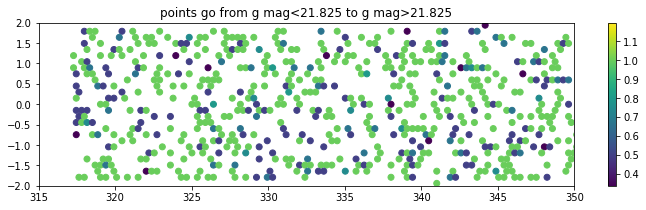

In [50]:
bad_arr,good_arr,ra,dec = goot_out_ratio(in_g , out_g, '<', '>', 21.825,quanti = 'g mag')
good_arr_new = good_arr[good_arr>0]

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


369644 16842 0.04556275768036273 372756


/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in log10


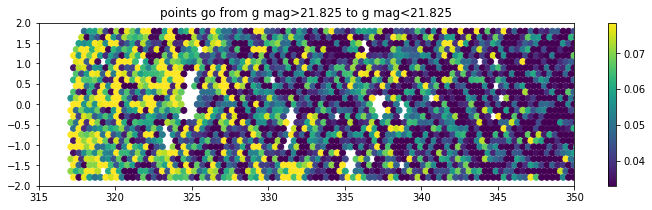

In [51]:
bad_arr,good_arr,ra,dec = goot_out_ratio(in_g , out_g, '>', '<', 21.825, quanti = 'g mag')

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


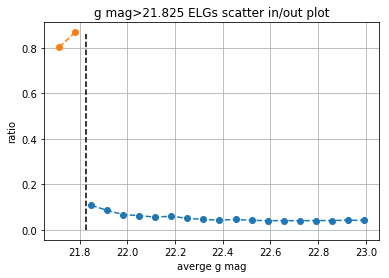

In [136]:
scatter_contamination_plotting(in_g , out_g, '>', '<', 21.825, quanti = 'g mag')

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':


317319 115148 0.3628777350237458 372756


/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in log10


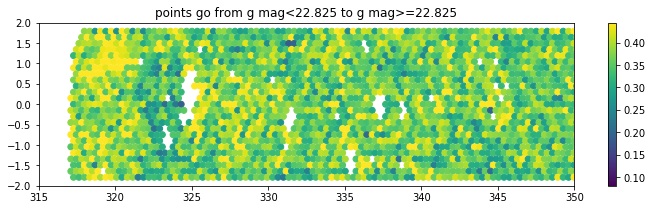

In [52]:
bad_arr,good_arr,ra,dec = goot_out_ratio(in_g, out_g, '<', '>=', 22.825, quanti = 'g mag')

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in log10


55437 7006 0.1263776899904396 372756


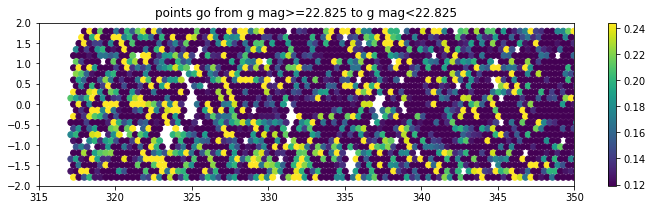

In [53]:
bad_arr,good_arr,ra,dec = goot_out_ratio(in_g, out_g, '>=', '<', 22.825, quanti = 'g mag')

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


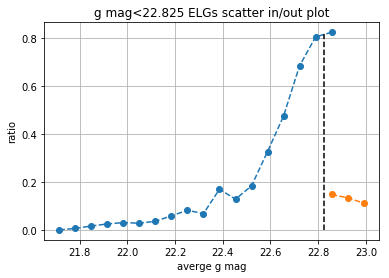

In [137]:
scatter_contamination_plotting(in_g, out_g, '<', '>=', 22.825, quanti = 'g mag')

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':


296408 13056 0.04404739413241208 372756


/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in log10


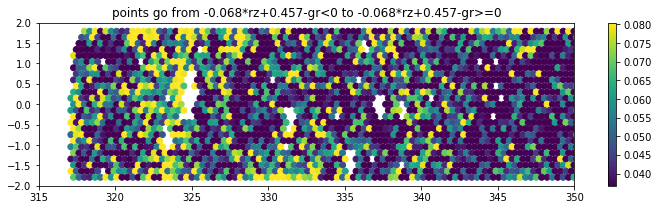

In [138]:
#-0.068*rz+0.457-gr<0
INPUT = -0.068*(in_r-in_z)+0.457-(in_g-in_r)
OUTPUT = -0.068*(out_r-out_z)+0.457-(out_g-out_r)
bad_arr,good_arr,ra,dec = goot_out_ratio(INPUT, OUTPUT, '<', '>=', 0, quanti = '-0.068*rz+0.457-gr')

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in log10


76348 23973 0.31399643736574634 372756


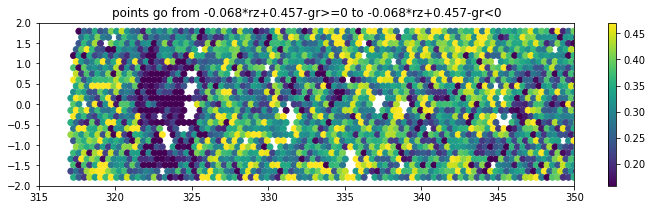

In [56]:
#-0.068*rz+0.457-gr<0
INPUT = -0.068*(in_r-in_z)+0.457-(in_g-in_r)
OUTPUT = -0.068*(out_r-out_z)+0.457-(out_g-out_r)
bad_arr,good_arr,ra,dec = goot_out_ratio(INPUT, OUTPUT, '>=', '<', 0, quanti = '-0.068*rz+0.457-gr')

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


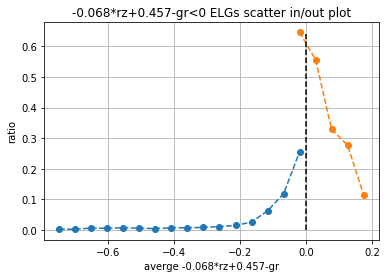

In [140]:
scatter_contamination_plotting(INPUT, OUTPUT, '<', '>=', 0, quanti = '-0.068*rz+0.457-gr')

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less_equal
  if __name__ == '__main__':


342837 46825 0.1365809407969385 372756


/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in log10


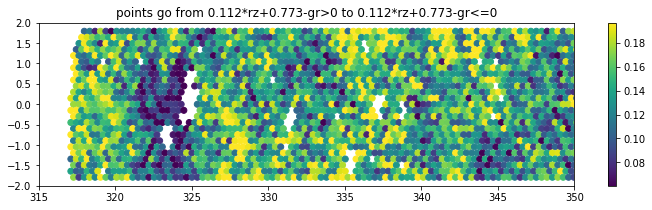

In [141]:
#0.112*rz+0.773-gr>0
INPUT = 0.112*(in_r-in_z)+0.773-(in_g-in_r)
OUTPUT = 0.112*(out_r-out_z)+0.773-(out_g-out_r)
bad_arr,good_arr,ra,dec = goot_out_ratio(INPUT, OUTPUT, '>', '<=', 0, quanti = '0.112*rz+0.773-gr')

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in log10


29919 3409 0.11394097396303353 372756


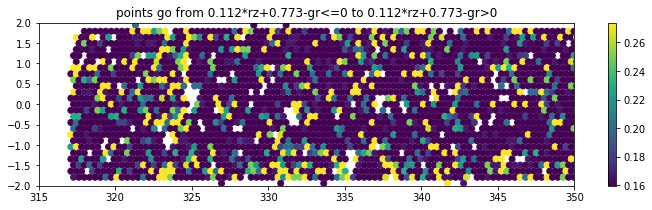

In [57]:
#0.112*rz+0.773-gr>0
INPUT = 0.112*(in_r-in_z)+0.773-(in_g-in_r)
OUTPUT = 0.112*(out_r-out_z)+0.773-(out_g-out_r)
bad_arr,good_arr,ra,dec = goot_out_ratio(INPUT, OUTPUT, '<=', '>', 0, quanti = '0.112*rz+0.773-gr')

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less_equal
  if __name__ == '__main__':
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


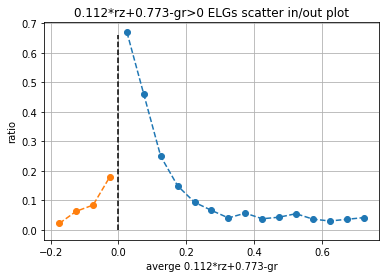

In [142]:
scatter_contamination_plotting(INPUT, OUTPUT, '>', '<=', 0, quanti = '0.112*rz+0.773-gr')

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':


325760 39716 0.12191797642436149 372756


/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in log10


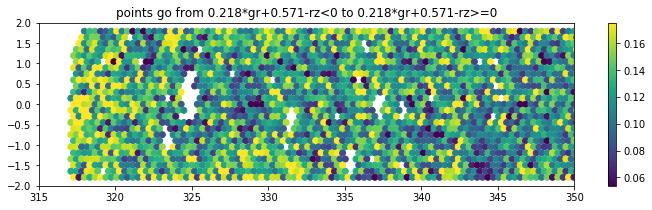

In [143]:
#0.218*gr+0.571-rz<0
INPUT = 0.218*(in_g-in_r)+0.571-(in_r-in_z)
OUTPUT = 0.218*(out_g-out_r)+0.571-(out_r-out_z)
bad_arr,good_arr,ra,dec = goot_out_ratio(INPUT, OUTPUT, '<', '>=', 0, '0.218*gr+0.571-rz')

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less_equal
  if __name__ == '__main__':
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in log10


46996 8169 0.17382330411098817 372756


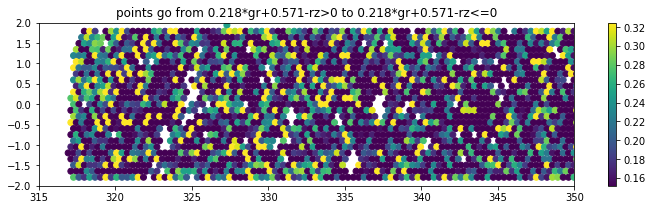

In [59]:
#0.218*gr+0.571-rz<0
INPUT = 0.218*(in_g-in_r)+0.571-(in_r-in_z)
OUTPUT = 0.218*(out_g-out_r)+0.571-(out_r-out_z)
bad_arr,good_arr,ra,dec = goot_out_ratio(INPUT, OUTPUT, '>', '<=', 0, '0.218*gr+0.571-rz')

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


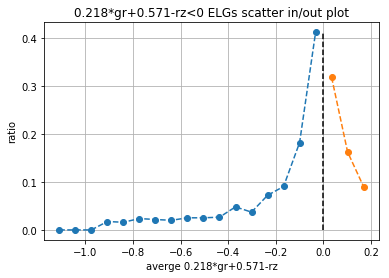

In [144]:
scatter_contamination_plotting(INPUT, OUTPUT, '<', '>=', 0, '0.218*gr+0.571-rz')

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':


325760 39716 0.12191797642436149 372756


/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in log10


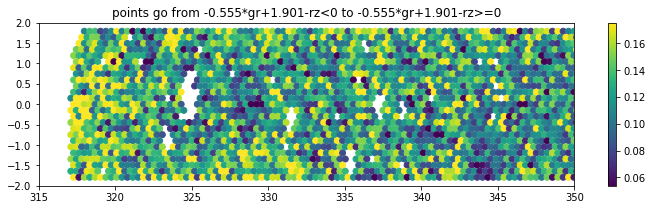

In [147]:
#-0.555*gr+1.901-rz
INPUT = 0.218*(in_g-in_r)+0.571-(in_r-in_z)
OUTPUT = 0.218*(out_g-out_r)+0.571-(out_r-out_z)
bad_arr,good_arr,ra,dec = goot_out_ratio(INPUT, OUTPUT, '<', '>=', 0, '-0.555*gr+1.901-rz')

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less_equal
  if __name__ == '__main__':
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in log10


46996 8169 0.17382330411098817 372756


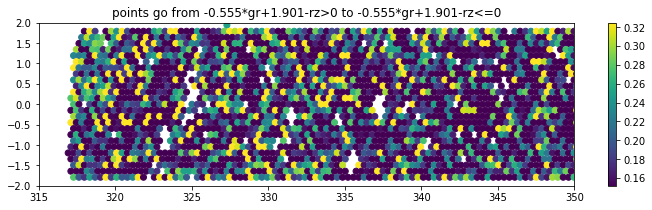

In [62]:
#-0.555*gr+1.901-rz
INPUT = 0.218*(in_g-in_r)+0.571-(in_r-in_z)
OUTPUT = 0.218*(out_g-out_r)+0.571-(out_r-out_z)
bad_arr,good_arr,ra,dec = goot_out_ratio(INPUT, OUTPUT, '>', '<=', 0, '-0.555*gr+1.901-rz')

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


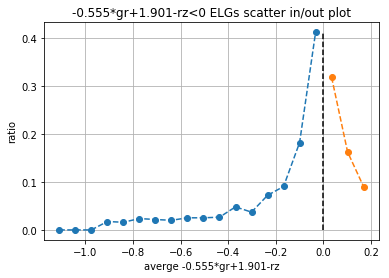

In [148]:
scatter_contamination_plotting(INPUT, OUTPUT, '<', '>=', 0, '-0.555*gr+1.901-rz')